In [1]:
# import modules
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

In [2]:
# We define the miners as the python class. This would help us to easily extend the model to the case of many agents.
# Each miner have some features: id, number of actions, cost variable, q-table and action in each iteration
# Each miner has some functionalities such as step (play the game for one step) and update his q-table.
# q-table of each miner consists of the following:
    # set of actions: hash values he/she can choose. Size of the action set for each miner i is [0 , int(R/c_i)]
    # state variables: which consists of two variables; hash value in the previous step, share of hash value in the previous step (hash / total_hash)
        # The size of the set of state variables for each miner is   [0 , int(R/c_i)] * [0 , 100], the first one is the size of the action set and the second one is the probability from 0 to 100.
        
# size of the seconf state variable is the same foe all the agents and it is equal to 100.        
num_pr = 100 

# overall reward
R = 100

class Miner():
    def __init__(self, u_id , c , epsilon): #epsilon = 0.99997
        self.id = u_id
        self.num_actions = int(R/c)
        self.cost = c
        self.epsilon = epsilon
        self.q_table = np.zeros(( self.num_actions , num_pr+1 , self.num_actions+1)) # first: number of actions, second: previous probanility, third: previous hash
        self.action = 0
        
    def step(self , n , old_pr , old_hash): # n: number of iteration
        epsilon = self.epsilon ** n  # calculate the epsilon in each iteration 
        if random.random() < epsilon:
            action = random.randint(0 , self.num_actions - 1) # explore
        else:
            action = np.argmax(self.q_table[: , old_pr , old_hash ]) # exploit
            
        self.action = action
        return self.action
        
    def update_qtable(self , new_pr , new_hash , old_pr , old_hash , reward , alpha , gamma):  # old state: old_pr, old_hash| new state: new_pr , new_hash
        max_q = np.max(self.q_table[: , new_pr , new_hash]) # find the action with highest q-value in the new state
        self.q_table[self.action , old_pr , old_hash] = (1-alpha)*self.q_table[self.action , old_pr , old_hash] + alpha*(reward + gamma*max_q) # update q-table
        
        

In [3]:
# create the market
n_miner = 5
n_iter = 400000
Miners=[] # list of miners, whose elements are miner classes

# cost vector of all the miners
# note that the size of the cost list should be equal to the n_miners
c=[1,1,1,1,1]

#gamma = 0.1
old_pr = [0]*n_miner
old_hash = [0]*n_miner
EPS =  0.002**(1/n_iter) # epsilon should be set as a function of the number of iterations, so that in the last iteration it ends to 0.2%
alpha = 0.05 # define alpha
gamma = 0.05 # define gamma
# create the miners
for i in range(n_miner):
    Miners.append(Miner(i , c[i] , EPS)) # create list of moners
# create a for loop containing the episodes
H=[]
REWARDS = []
for i in range(n_iter):
    #print(i)
    hashes = []
    # get miners actions
    for m in range(n_miner):
        hashes.append(Miners[m].step(i , old_pr[m] , old_hash[m])) # miners taking actions
    # get states; probabilities of winning 
    if max(hashes)==0:
        prs = [0]*n_miner # exclude cases where all the chosen actions are zeros.
    else:
        prs = [round(hashes[k]/sum(hashes) , 2) for k in range(n_miner)] # 0<prs[i]<1
    
    H.append(hashes)
    #0<probs[i]<100
    probs = [int(prs[k]*100) for k in range(n_miner)] # calculate the probability of winning the reward, or equivalently, agents i hash/ sum_hash 
    # get rewards as pr(win)*R - cost*hash
    rewards = [prs[l]*R-c[l]*hashes[l] for l in range(n_miner)] # calculate reward for each miner
    REWARDS.append(rewards)
    
    # update q-tables
    for j in range(n_miner):
        Miners[j].update_qtable(probs[j] , hashes[j] , old_pr[j] , old_hash[j] , rewards[j] , alpha , gamma) # each miner update his/her q-table
    # set old states as new states
    old_pr = probs
    old_hash = hashes
    
              

In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

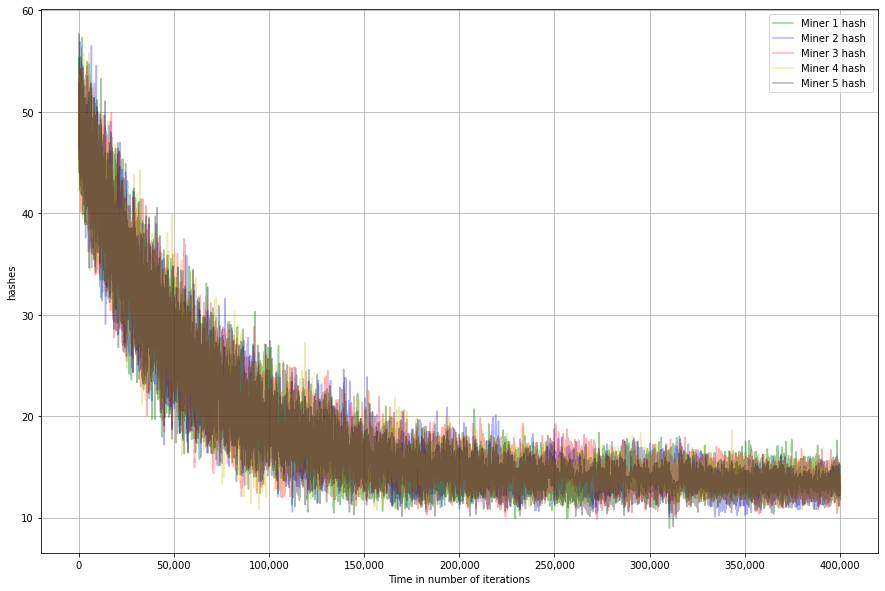

In [8]:
# ploting the results (hashes)

from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
# fetch hash value from the list of all hashes, H
h1 = [H[i][0] for i in range(n_iter)]
h2 = [H[i][1] for i in range(n_iter)]
h3 = [H[i][2] for i in range(n_iter)]
h4 = [H[i][3] for i in range(n_iter)]
h5 = [H[i][4] for i in range(n_iter)]


# calculate the moving average of hashes for each miner
hashes_1 = moving_average(h1 , 100)
hashes_2 = moving_average(h2 , 100)
hashes_3 = moving_average(h3 , 100)
hashes_4 = moving_average(h4 , 100)
hashes_5 = moving_average(h5 , 100)

x_axes = moving_average( list(range(0 , n_iter )) , 100)
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [15, 10]

# plot the hashes
plt.plot(x_axes , hashes_1 , alpha = 0.4 , color = 'g' , label = 'Miner 1 hash ') 
plt.plot(x_axes , hashes_2 , alpha = 0.3 , color = 'b' , label = 'Miner 2 hash')
plt.plot(x_axes , hashes_3 , alpha = 0.3 , color = 'r' , label = 'Miner 3 hash') 
plt.plot(x_axes , hashes_4 , alpha = 0.3 , color = 'y' , label = 'Miner 4 hash') 
plt.plot(x_axes , hashes_5 , alpha = 0.3 , color = 'k' , label = 'Miner 5 hash') 


plt.xlabel('Time in number of iterations')
plt.ylabel('hashes')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.legend()
plt.grid()
#plt.show()
plt.savefig('results_hashes.jpg')

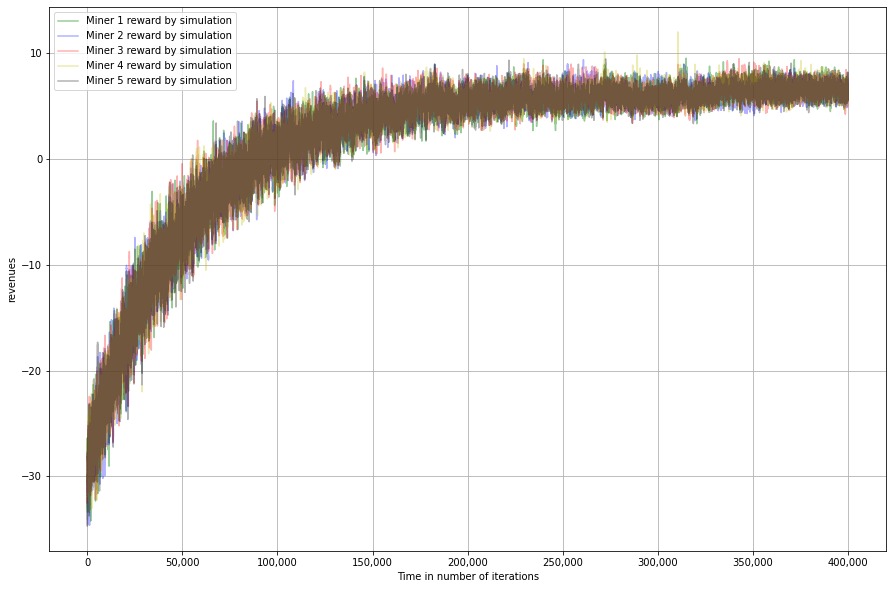

In [7]:
# plot the results (rewards) 

# fetch the reward value for each miner at each step
rew_1 = [REWARDS[i][0] for i in range(n_iter)]
rew_2 = [REWARDS[i][1] for i in range(n_iter)]
rew_3 = [REWARDS[i][2] for i in range(n_iter)]
rew_4 = [REWARDS[i][3] for i in range(n_iter)]
rew_5 = [REWARDS[i][4] for i in range(n_iter)]

# calculate the moving average of the rewards for each miner
rews_1 = moving_average(rew_1 , 100)
rews_2 = moving_average(rew_2 , 100)
rews_3 = moving_average(rew_3 , 100)
rews_4 = moving_average(rew_4 , 100)
rews_5 = moving_average(rew_5 , 100)

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [15, 10]

# plot the rewards
plt.plot(x_axes , rews_1 , alpha = 0.4 , color = 'g' , label = 'Miner 1 reward by simulation') 
plt.plot(x_axes , rews_2 , alpha = 0.3 , color = 'b' , label = 'Miner 2 reward by simulation')
plt.plot(x_axes , rews_3 , alpha = 0.3 , color = 'r' , label = 'Miner 3 reward by simulation') 
plt.plot(x_axes , rews_4 , alpha = 0.3 , color = 'y' , label = 'Miner 4 reward by simulation') 
plt.plot(x_axes , rews_5 , alpha = 0.3 , color = 'k' , label = 'Miner 5 reward by simulation') 



plt.xlabel('Time in number of iterations')
plt.ylabel('revenues')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.legend()
plt.grid()
#plt.show()
plt.savefig('results_revenue.jpg')